# Regression
It consists of predicting a cntinuous value instead of a discrete label.

**Boston Housing Price dataset:** It has few data points (compared to the classification cases): only 506 (404 training examples and 102 test examples). Each feature in the input data has a different scale. The targets are the median values of homes, in thousands of dollars (mid-1970s).

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Preparing the data
Sinde the features are in different ranges, a good practice is to do **feature-wise normalization:** for each feature in the input data (so, a column in the data matrix), substract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has unit standar deviation.

In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

**IMPORTANT:** the quantities used for normalizing the test data (```mean``` and ```std```) are computed using the training data => NEVER use in the workflow *any* quantity computed on the test data.

# Building the network
Few samples are available, so the NN should also be very small, because *less training data -> worse overfit*.

In [3]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

The network ends with a *single unit* and **no activation**, which is a typical setuo for scalar regression, because applying an activation function would constrain the range the ouptup can take.

The NN is compiled with the ```mse``` loss function (*mean squared error*), the square of the difference between the predictions and the targets.

The monitored metric is ```mae``` (*mean absolute error*), the absolute value of the difference between predictions and the targets.

# Validation of the approach -> K-fold validation
Since there are so few data points, the validation set would end up being very small. As consecuence, the validation scores might have a high *variance* with regard to the validation split.

So the best practice is to use ***K-fold cross-validation***, which consists of splitting the available data into *K* partitions (typically, *K* = 4 or 5), instantiating *K* identical models (which is why the building of the model is in a fucntion), and training each one on *K - 1* partitions while evaluation on the remaining partition. 

=> The validation score for the model is the *average* of the *K* validation scores obtained.

In [4]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [5]:
print(all_scores)
print("Average: ",np.mean(all_scores))

[2.0110268592834473, 2.291250467300415, 2.645113229751587, 2.4099209308624268]
Average:  2.339327871799469


Test by training longer: 500 epochs

In [6]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
        
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
            validation_data=(val_data, val_targets),
            epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


And to compute the average of the per-epoch ```mae``` scores for all folds:

In [7]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

To see the plot:

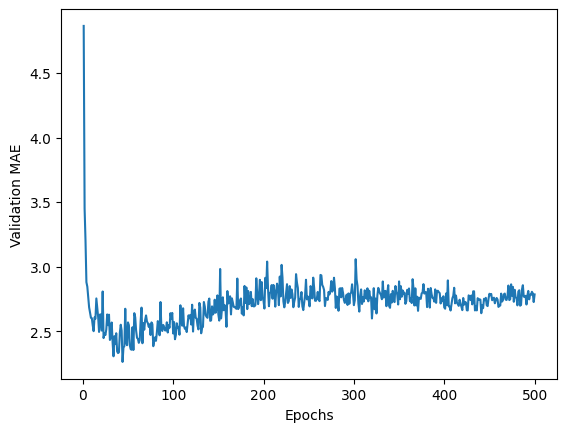

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Because of scaling issues and relatively high variance, it's difficult to see the plot. How to fix this?
- omit the first 10 data points, as they're in a different scale from the rest
- replace each point with an exponential moving average of the previous points to obtain a smooth curve

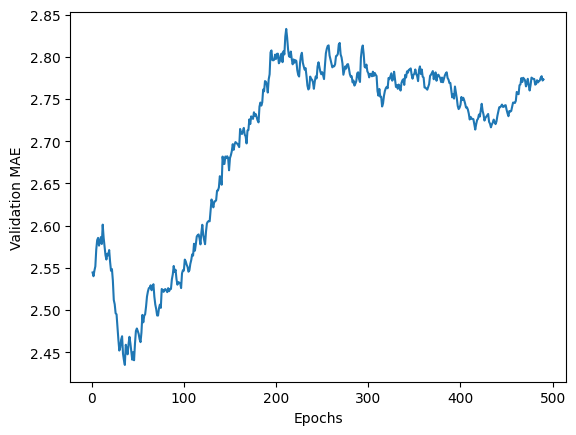

In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

At the point were validation ```mae``` stops improving (in this case, after 50-80 epochs), starts the overfitting.

Once the tuning of the paramenters is finished (based on the results of K-fold validation), comes the time to train a final production model on all of the training data:

In [10]:
model = build_model()
model.fit(train_data, train_targets,
        epochs=80, batch_size=16, verbose=0)


And then look at the performance on the test data:

In [13]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score, " ->  this indicates the results are still off by about: $", (int)(test_mae_score*1000))

4/4 [==============================] - 0s 1ms/step - loss: 16.4383 - mae: 2.6128
2.6127727031707764  ->  this indicates the results are still off by about: $ 2612
